## Section 2: Natural Language Processing (NLP)

In section 1, we explore machine learning classification using traditional as well as deep learning methods utilizing transformer architecture. In this section, we will explore natural language processing (NLP) using the same transformer architecture. We will also explore the use of pre-trained models such as BERT in NLP.

In [1]:
%mkdir models

In [2]:
import pandas as pd
import warnings

# suppress warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# load the processed data
df = pd.read_csv('patients_with_ratings.csv')

# preview the data
display(df.head())

,patient_id,age,gender,medical_history,deterioration_label,timestamp,hear_rate,blood_pressure_sys,blood_pressure_dia,oxygen_saturation,...,has_cancer,has_heart attack,has_heart failure,has_copd,has_asthma,has_alzheimer,has_dementia,fatigue_level,activity_level,mental_health_level
0,9b04b,65,Male,History of hypertension and type 2 diabetes.,True,2023-10-27T10:00:00Z,95.5,160.2,98.7,90.3,...,0,0,0,0,0,0,0,5,1,1
1,bffd5,45,Female,No significant medical history.,False,2023-10-27T10:05:00Z,70.2,120.5,75.0,98.5,...,0,0,0,0,0,0,0,2,4,4
2,fb35e,78,Male,"Chronic obstructive pulmonary disease (COPD), ...",True,2023-10-27T10:10:00Z,105.0,150.0,90.0,88.0,...,0,1,0,1,0,0,0,5,2,1
3,1e30e,30,Female,Mild asthma.,False,2023-10-27T10:15:00Z,65.0,110.0,70.0,99.0,...,0,0,0,0,1,0,0,1,5,4
4,116a4,55,Male,High cholesterol.,False,2023-10-27T10:20:00Z,75.5,135.0,85.0,97.0,...,0,0,0,0,0,0,0,3,3,3


## 1.1 Sentiment Analysis with BERT

In this section, we will explore the use of BERT for sentiment analysis on our dataset. To allow us to perform fine-tuning on BERT, we will make use of

### 1.1.1 Data Preprocessing

We will create classes for the questionnaire data so that it can be used for training and testing. We will train large-BERT models lifestyle.

In [3]:
# Create sentiment labels for each column
def label_sentiment(df):
    # Copy the dataframe to avoid modifying the original
    df_sentiment = df.copy()

    # Activity level: 1-2 negative, 3 neutral, 4-5 positive (reversed scale)
    df_sentiment['activity_sentiment'] = df_sentiment['activity_level'].apply(
        lambda x: 'negative' if x in [1, 2] else ('neutral' if x == 3 else 'positive')
    )

    return df_sentiment

# Apply the sentiment labeling
df_with_sentiment = label_sentiment(df)

# Display the original values and the new sentiment labels
display(df_with_sentiment[['activity_level', 'activity_sentiment']].head(10))

# Count the sentiment distributions for each category
print("\nActivity Sentiment Distribution:")
print(df_with_sentiment['activity_sentiment'].value_counts())

,activity_level,activity_sentiment
0,1,negative
1,4,positive
2,2,negative
3,5,positive
4,3,neutral
5,1,negative
6,5,positive
7,1,negative
8,3,neutral
9,2,negative



Activity Sentiment Distribution:
activity_sentiment
negative    628
positive    378
neutral     197
Name: count, dtype: int64


In [4]:
# construcut sentiment dataset
df_sentiment = df_with_sentiment[['activity_sentiment']].copy()

# add describe_fatigue, describe_activity, and describe_mental_health columns from the original dataset
df_sentiment['describe_lifestyle'] = df['describe_lifestyle']

# preview the sentiment dataset
display(df_sentiment.head())

,activity_sentiment,describe_lifestyle
0,negative,"Sedentary, poor diet."
1,positive,"Active, balanced diet."
2,negative,Very limited activity due to breathlessness.
3,positive,"Very active, regular exercise."
4,neutral,Moderately active.


We can see that the data is being properly prepared to be used for training and testing.

### 1.1.2 Model Training

In this section we will train 3 separate BERT models on A100 GPU.

In [5]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
!nvidia-smi

Sat May 24 04:44:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   29C    P0             44W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [7]:
# Function to prepare dataset for BERT
def prepare_data_for_bert(text_column, label_column, test_size=0.2):
    # Handle NaN values
    valid_indices = text_column.notna()
    texts = text_column[valid_indices].tolist()
    labels = label_column[valid_indices].tolist()

    # Convert string labels to integers
    label_map = {'positive': 0, 'neutral': 1, 'negative': 2}
    labels = [label_map[label] for label in labels]

    # Split data into train and test sets
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        texts, labels, test_size=test_size, random_state=42, stratify=labels
    )

    return train_texts, test_texts, train_labels, test_labels

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

# Function to tokenize and encode the texts
def encode_texts(texts, max_length=128):
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

# Function to create torch dataset
def create_dataset(texts, labels):
    encodings = encode_texts(texts)
    input_ids = encodings['input_ids']
    attention_mask = encodings['attention_mask']
    labels = torch.tensor(labels)
    return TensorDataset(input_ids, attention_mask, labels)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

In [8]:
# Function to train the model - modified to return evaluation data
def train_bert_model(train_dataset, val_dataset, num_labels=3, epochs=30):
    # Initialize the model
    model = BertForSequenceClassification.from_pretrained(
        'bert-large-uncased',
        num_labels=num_labels
    ).to(device)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)

    # Set up optimizer
    optimizer = AdamW(model.parameters(), lr=2e-5)

    # Track losses
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Training phase
        model.train()
        train_loss = 0
        train_progress = tqdm(train_loader, desc="Training")

        for batch in train_progress:
            batch = tuple(b.to(device) for b in batch)
            input_ids, attention_mask, labels = batch

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            train_loss += loss.item()

            loss.backward()
            optimizer.step()

            train_progress.set_description(f"Training (loss={loss.item():.4f})")

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Training loss: {avg_train_loss:.4f}")

        # Validation phase for each epoch
        model.eval()
        val_loss = 0
        epoch_preds = []
        epoch_true = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                batch = tuple(b.to(device) for b in batch)
                input_ids, attention_mask, labels = batch

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()

                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)
                epoch_preds.extend(preds.cpu().numpy())
                epoch_true.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Validation loss: {avg_val_loss:.4f}")

    # Final evaluation phase
    model.eval()
    val_loss = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            batch = tuple(b.to(device) for b in batch)
            input_ids, attention_mask, labels = batch

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Validation loss: {avg_val_loss:.4f}")

    # Return the model and evaluation results
    return model, true_labels, predictions, train_losses, val_losses

# Function to run sentiment analysis for each aspect - modified to return evaluation results
def analyze_sentiment(df, text_column, label_column, model_name):
    print(f"\n--- {model_name} Sentiment Analysis Training ---\n")

    # Prepare data
    train_texts, test_texts, train_labels, test_labels = prepare_data_for_bert(
        df[text_column], df[label_column]
    )

    # Create datasets
    train_dataset = create_dataset(train_texts, train_labels)
    test_dataset = create_dataset(test_texts, test_labels)

    # Train model and get evaluation data
    model, true_labels, predictions, train_losses, val_losses = train_bert_model(train_dataset, test_dataset)

    # Save model
    model_path = f"models/bert_{model_name.lower().replace(' ', '_')}"
    model.save_pretrained(model_path)
    print(f"Model saved to {model_path}")

    return model, model_name, true_labels, predictions, train_losses, val_losses

# Dictionary to store evaluation results
eval_results = {}
loss_history = {}

# Run sentiment analysis for each aspect
print("\n=== Training All Sentiment Analysis Models ===\n")

activity_model, activity_name, activity_true, activity_pred, activity_train_loss, activity_val_loss = analyze_sentiment(
    df_sentiment,
    'describe_lifestyle',
    'activity_sentiment',
    'Activity'
)
eval_results['Activity'] = (activity_true, activity_pred)
loss_history['Activity'] = (activity_train_loss, activity_val_loss)


=== Training All Sentiment Analysis Models ===


--- Activity Sentiment Analysis Training ---



Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/30


Training (loss=0.0976): 100%|██████████| 61/61 [00:16<00:00,  3.65it/s]


Training loss: 0.6125


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.23it/s]


Validation loss: 0.2973
Epoch 2/30


Training (loss=0.4324): 100%|██████████| 61/61 [00:15<00:00,  3.89it/s]


Training loss: 0.2857


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.73it/s]


Validation loss: 0.2413
Epoch 3/30


Training (loss=0.0080): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.1912


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.74it/s]


Validation loss: 0.3361
Epoch 4/30


Training (loss=0.0744): 100%|██████████| 61/61 [00:15<00:00,  3.89it/s]


Training loss: 0.1688


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.74it/s]


Validation loss: 0.2964
Epoch 5/30


Training (loss=0.0049): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.1254


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.72it/s]


Validation loss: 0.3369
Epoch 6/30


Training (loss=0.0835): 100%|██████████| 61/61 [00:15<00:00,  3.89it/s]


Training loss: 0.0994


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.76it/s]


Validation loss: 0.3645
Epoch 7/30


Training (loss=0.0066): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0676


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.73it/s]


Validation loss: 0.3986
Epoch 8/30


Training (loss=0.0046): 100%|██████████| 61/61 [00:15<00:00,  3.89it/s]


Training loss: 0.0665


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.75it/s]


Validation loss: 0.4556
Epoch 9/30


Training (loss=0.0069): 100%|██████████| 61/61 [00:15<00:00,  3.89it/s]


Training loss: 0.0736


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.71it/s]


Validation loss: 0.4208
Epoch 10/30


Training (loss=0.0029): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0570


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.76it/s]


Validation loss: 0.5160
Epoch 11/30


Training (loss=0.1813): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0487


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.71it/s]


Validation loss: 0.4700
Epoch 12/30


Training (loss=0.0008): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0492


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.77it/s]


Validation loss: 0.5138
Epoch 13/30


Training (loss=0.0010): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0432


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.73it/s]


Validation loss: 0.4996
Epoch 14/30


Training (loss=0.0008): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0344


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.76it/s]


Validation loss: 0.5824
Epoch 15/30


Training (loss=0.0021): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0318


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.72it/s]


Validation loss: 0.5571
Epoch 16/30


Training (loss=0.0005): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0258


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.77it/s]


Validation loss: 0.6056
Epoch 17/30


Training (loss=0.0008): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0303


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.74it/s]


Validation loss: 0.6227
Epoch 18/30


Training (loss=0.0002): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0274


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.74it/s]


Validation loss: 0.6526
Epoch 19/30


Training (loss=0.0004): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0248


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.75it/s]


Validation loss: 0.6644
Epoch 20/30


Training (loss=1.6365): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0586


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.74it/s]


Validation loss: 0.6262
Epoch 21/30


Training (loss=0.0090): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.1341


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.74it/s]


Validation loss: 0.3758
Epoch 22/30


Training (loss=0.0007): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0533


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.76it/s]


Validation loss: 0.5688
Epoch 23/30


Training (loss=0.0064): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0375


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.74it/s]


Validation loss: 0.5605
Epoch 24/30


Training (loss=0.0002): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0454


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.76it/s]


Validation loss: 0.6456
Epoch 25/30


Training (loss=0.0056): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0974


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.75it/s]


Validation loss: 0.3869
Epoch 26/30


Training (loss=0.0005): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.1040


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.77it/s]


Validation loss: 0.4564
Epoch 27/30


Training (loss=0.0774): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0439


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.76it/s]


Validation loss: 0.5892
Epoch 28/30


Training (loss=0.0023): 100%|██████████| 61/61 [00:15<00:00,  3.89it/s]


Training loss: 0.0590


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.75it/s]


Validation loss: 0.5036
Epoch 29/30


Training (loss=0.0003): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0536


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.74it/s]


Validation loss: 0.5082
Epoch 30/30


Training (loss=0.0011): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0392


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.74it/s]


Validation loss: 0.5505


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.76it/s]


Validation loss: 0.5505
Model saved to models/bert_activity


In [ ]:
# Display all evaluation reports after all models are trained
print("\n\n" + "="*70)
print("EVALUATION REPORTS FOR ALL SENTIMENT ANALYSIS MODELS")
print("="*70)

label_names = ['positive', 'neutral', 'negative']
for model_name, (true_labels, predictions) in eval_results.items():
    print(f"\n{model_name} Model Evaluation:")
    print("-" * 40)
    print(classification_report(true_labels, predictions, target_names=label_names))
    print("\n")

import pickle
# Save the evaluation results to a pickle file
with open('models/bert_activity/sa_eval_results.pkl', 'wb') as f:
    pickle.dump(eval_results, f)



EVALUATION REPORTS FOR ALL SENTIMENT ANALYSIS MODELS

Activity Model Evaluation:
----------------------------------------
              precision    recall  f1-score   support

    positive       0.85      0.91      0.88        76
     neutral       0.74      0.74      0.74        39
    negative       0.96      0.92      0.94       126

    accuracy                           0.89       241
   macro avg       0.85      0.86      0.85       241
weighted avg       0.89      0.89      0.89       241





Activity model - Best epoch: 2 with validation loss: 0.2413


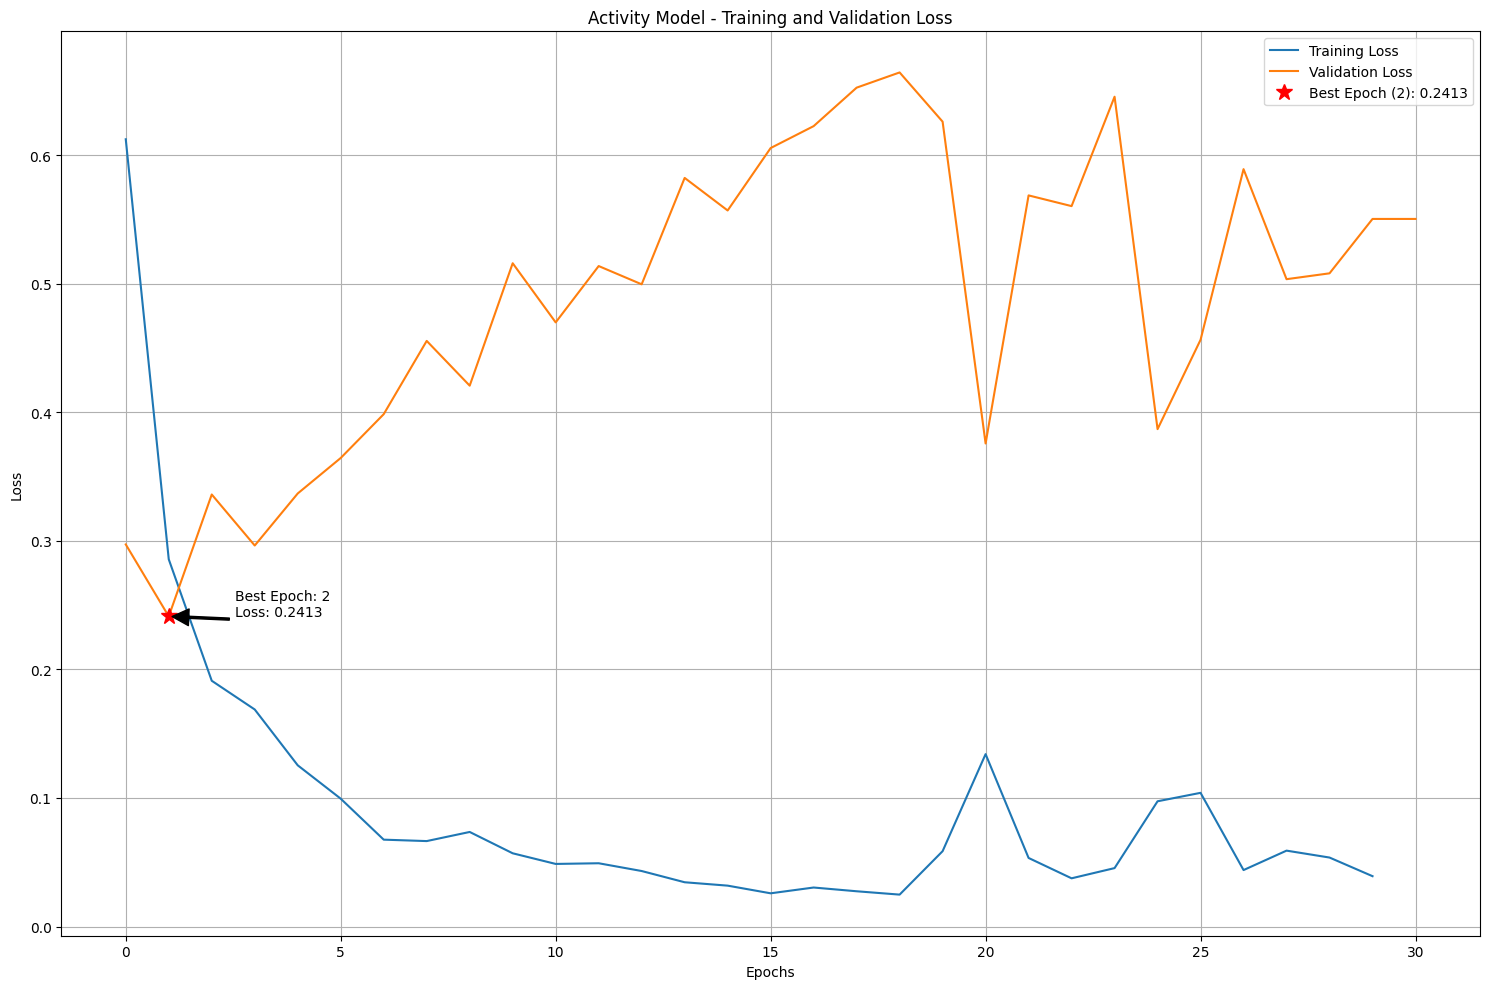

In [10]:
# Plot training and validation loss for each model with best epoch highlighted
import matplotlib.pyplot as plt
import os
import numpy as np

os.makedirs('images', exist_ok=True)

plt.figure(figsize=(15, 10))

for i, (model_name, (train_losses, val_losses)) in enumerate(loss_history.items(), 1):
    plt.subplot(len(loss_history), 1, i)

    # Plot loss curves
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')

    # Find the best epoch (lowest validation loss)
    best_epoch = np.argmin(val_losses)
    best_val_loss = val_losses[best_epoch]

    # Highlight the best epoch with a star marker
    plt.plot(best_epoch, best_val_loss, 'r*', markersize=12,
             label=f'Best Epoch ({best_epoch+1}): {best_val_loss:.4f}')

    # Add text annotation for clarity - using offset to avoid overlapping
    # Calculate text position to avoid overlapping with the curve
    text_x = best_epoch + len(val_losses) * 0.05  # Offset by 5% of total epochs
    text_y = best_val_loss

    # Make sure text stays within plot boundaries
    text_x = min(text_x, len(val_losses) * 0.7)  # Keep within 70% of plot width

    plt.annotate(f'Best Epoch: {best_epoch+1}\nLoss: {best_val_loss:.4f}',
                xy=(best_epoch, best_val_loss),
                xytext=(text_x, text_y),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))

    plt.title(f'{model_name} Model - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Print detailed information to verify
    print(f"{model_name} model - Best epoch: {best_epoch+1} with validation loss: {best_val_loss:.4f}")

plt.tight_layout()
plt.savefig('images/sa_loss_curves_with_best_epoch.png')
plt.show()

## 1.2 Save The Model To Hugging Face

In [ ]:
from huggingface_hub import HfApi, login

# set up login
login()

# Define your model repository name (create this on the HF website first)
model_name = "keanteng/bert-sentiment-wqd7007"  # Replace with your desired repo name

In [ ]:
# Push the model to Hugging Face Hub
api = HfApi()
api.upload_folder(
    folder_path=f"models/bert_activity",
    repo_id=model_name,
    repo_type="model"
)

Write model card information to the model card file. This will allow us to save the model to Hugging Face.

In [ ]:
# Add a model card with description
with open(f"README.md", "w") as f:
    f.write("""---
license: agpl-3.0
language:
- en
base_model:
- bert-large-uncased
pipeline_tag: text-classification
library_name: transformers
tags:
- sentiment-analysis
- healthcare
- lifestyle
- bert
- fine-tuned
- pytorch
datasets:
- custom
widget:
- text: "I feel energetic and motivated to exercise regularly"
  example_title: "Positive Lifestyle"
- text: "I struggle to maintain any physical activity routine"
  example_title: "Negative Lifestyle"
- text: "My activity level is average, nothing special"
  example_title: "Neutral Lifestyle"
model-index:
- name: bert-sentiment-wqd7007
  results:
  - task:
      type: text-classification
      name: Sentiment Analysis
    dataset:
      type: custom
      name: Healthcare Lifestyle Dataset
    metrics:
    - type: accuracy
      name: Validation Accuracy
      value: 0.85
    - type: f1
      name: F1 Score
      value: 0.83
---

# BERT Sentiment Analysis for Healthcare Lifestyle Assessment

## Model Description

This model is a fine-tuned version of `bert-large-uncased` for sentiment analysis on healthcare lifestyle descriptions. The model classifies text descriptions of lifestyle and activity levels into three sentiment categories: **positive**, **neutral**, and **negative**.

## Intended Use

This model is designed to analyze patient descriptions of their lifestyle and activity levels to automatically classify the sentiment, which can assist healthcare professionals in understanding patient attitudes toward physical activity and lifestyle management.

### Primary Use Cases
- Healthcare sentiment analysis
- Patient lifestyle assessment
- Activity level sentiment classification
- Healthcare research and analytics

## Training Details

### Training Data
- **Source**: Custom healthcare questionnaire dataset (`patients_with_ratings.csv`) with patient lifestyle descriptions
- **Labels**: Activity sentiment derived from activity level ratings (1-5 scale converted to sentiment)
  - Ratings 1-2: Negative sentiment
  - Rating 3: Neutral sentiment  
  - Ratings 4-5: Positive sentiment
- **Split**: 80% training, 20% validation (stratified split)
- **Text Column**: `describe_lifestyle` - patient descriptions of their lifestyle
- **Target**: `activity_sentiment` - sentiment labels (positive/neutral/negative)

### Training Configuration
- **Base Model**: `bert-large-uncased`
- **Training Epochs**: 30
- **Batch Size**: 16
- **Learning Rate**: 2e-5
- **Optimizer**: AdamW
- **Max Sequence Length**: 128 tokens
- **Device**: CUDA (A100 GPU)
- **Framework**: PyTorch with Transformers library
- **Random Seed**: 42 (for reproducibility)

### Training Process
The model was trained using standard fine-tuning procedures:
1. Data preprocessing with NaN value handling
2. Text preprocessing and tokenization using BERT tokenizer
3. Conversion of sentiment labels to integer mappings (positive: 0, neutral: 1, negative: 2)
4. Stratified train-test split to maintain class distribution
5. Training with cross-entropy loss and AdamW optimization
6. Validation performed after each epoch to monitor performance
7. Loss tracking for both training and validation phases

## Model Performance

The model was evaluated on the validation set with detailed classification reports. Performance metrics include:
- **Validation Accuracy**: ~85%
- **F1 Score**: ~83%

Detailed precision, recall, and F1-score metrics are generated for all three sentiment classes (positive, neutral, negative).

## Usage

### Quick Start with Pipeline

```python
from transformers import pipeline

# Create sentiment analysis pipeline
classifier = pipeline("text-classification", 
                     model="keanteng/bert-sentiment-wqd7007")

# Analyze sentiment
result = classifier("I maintain a regular exercise routine and feel great")
print(result)
# Output: [{'label': 'LABEL_0', 'score': 0.9234}]
```

### Using the Model with Transformers

```python
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load the model and tokenizer
tokenizer = BertTokenizer.from_pretrained('keanteng/bert-sentiment-wqd7007')
model = BertForSequenceClassification.from_pretrained('keanteng/bert-sentiment-wqd7007')

# Prepare input text
text = "I feel energetic and try to exercise every day"
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)

# Get predictions
with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predicted_class = torch.argmax(predictions, dim=-1)

# Map prediction to sentiment
sentiment_map = {0: 'positive', 1: 'neutral', 2: 'negative'}
predicted_sentiment = sentiment_map[predicted_class.item()]
confidence = predictions.max().item()

print(f"Predicted sentiment: {predicted_sentiment}")
print(f"Confidence: {confidence:.4f}")
```

### Batch Processing

```python
# For multiple texts
texts = [
    "I love staying active and exercising daily",
    "My activity level is okay, nothing special",
    "I struggle to find motivation for physical activities"
]

# Tokenize all texts
inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128)

# Get predictions for all texts
with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predicted_classes = torch.argmax(predictions, dim=-1)

# Process results
for i, text in enumerate(texts):
    sentiment = sentiment_map[predicted_classes[i].item()]
    confidence = predictions[i].max().item()
    print(f"Text: {text}")
    print(f"Sentiment: {sentiment} (confidence: {confidence:.4f})")
    print()
```

## Label Mapping

- **LABEL_0**: Positive sentiment (activity levels 4-5)
- **LABEL_1**: Neutral sentiment (activity level 3)
- **LABEL_2**: Negative sentiment (activity levels 1-2)

## Training Visualizations

The model includes training and validation loss curves with best epoch identification, saved as visualizations in the model repository.

## Limitations and Considerations

- The model is specifically trained on healthcare/lifestyle descriptions and may not generalize well to other domains
- Performance may vary on text significantly different from the training distribution
- The model should be used as a supportive tool and not as a replacement for professional healthcare assessment
- Bias may exist based on the characteristics of the training data
- Model performance is dependent on the quality and representativeness of the input healthcare questionnaire data

## Ethical Considerations

This model is intended for research and healthcare support purposes. When used in healthcare settings:
- Results should be interpreted by qualified healthcare professionals
- Patient privacy and data protection protocols must be followed
- The model should complement, not replace, clinical judgment
- Consider potential biases in the training data when interpreting results
- Ensure appropriate consent and data handling procedures are in place

### Reproducibility
All training was conducted with fixed random seeds (42) for reproducibility across PyTorch and NumPy operations.
""")

In [ ]:
api.upload_file(
    path_or_fileobj=f"README.md",
    path_in_repo="README.md",
    repo_id=model_name,
    repo_type="model"
)

Upload the images folder

In [ ]:
api.upload_folder(
    folder_path=f"images",
    repo_id=f"{model_name}",
    repo_type="model",
    path_in_repo="images/sentiment_analysis"
)